In [15]:
%matplotlib inline
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import cv2
import numpy as np
from transformers import DefaultDataCollator
from transformers import TFViTForImageClassification, create_optimizer
from IPython.display import HTML
from transformers import BitImageProcessor, BitForImageClassification
import torch
from datasets import load_dataset

# Import Data

In [16]:
train_folder = ImageFolder(root="train")
val_folder = ImageFolder(root="train")
test_set = ImageFolder(root="test")
train_set, val_set = torch.utils.data.random_split(train_folder, [0.8,0.2])
val_set.dataset = val_folder

## Define data augmentations
The images are augmented every time they are called. So for every epoch, an image is augmented in a different way.

In [17]:
transform_train = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.RandomRotation((-35, 35)),
    transforms.CenterCrop(size=(900, 900)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Resize((384, 384)),
    
    
])
transform_val = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.CenterCrop(size=(900, 900)),
    transforms.ToTensor(),
    transforms.Resize((384, 384)),
])

train_set.dataset.transform=transform_train
val_set.dataset.transform=transform_val
test_set.transform=transform_val

/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


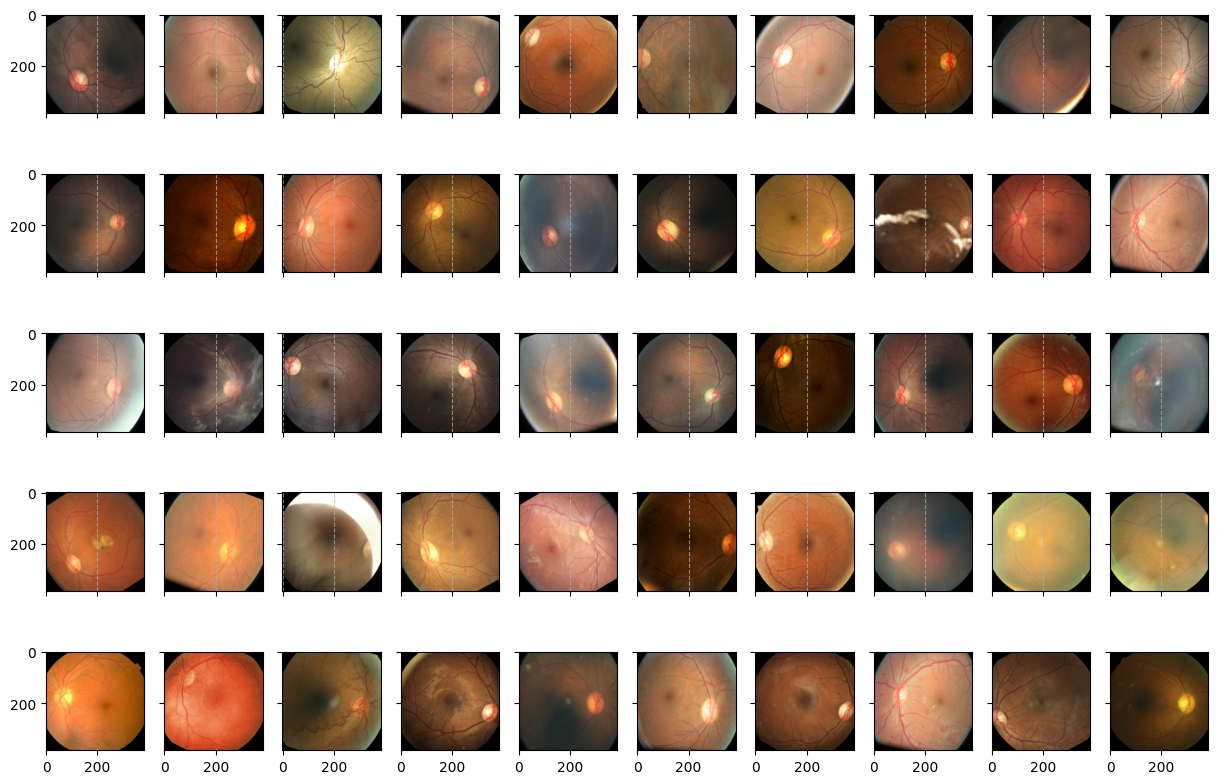

In [18]:
batch_size = int(64)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

figs, axs = plt.subplots(5, 10, figsize=(15, 10))
for col in range(1, 10):
    for ax in axs[:, col]:
        ax.yaxis.set_ticklabels([])

# Set x-grid only for the lower subplots
for row in range(4):
    for ax in axs[row, :]:
        ax.xaxis.set_ticklabels([])
        ax.xaxis.grid(True, linestyle='--', alpha=0.7)
axs = axs.flatten()

for i, (inputs, labels) in enumerate(train_loader):
    if i < 1:
        for j in range(50):
            #bs, ncrops, c, h, w = inputs.size()

            #img = np.array(inputs.view(-1, c, h, w)[j].permute(1, 2, 0) )
            img = np.array(inputs[j].permute(1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())  # Broadcasting rules apply
            axs[j].imshow(img)

    else:
        break
plt.show()

# Model
The model used is google's Big Transfer model published in 2020 which is based on a ResNetV2.

In [19]:
from transformers import ViTForImageClassification

# create optimizer wight weigh decay
model_name = "google/vit-base-patch32-384"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train

In [20]:
from transformers import TrainingArguments

epochs = 30
bs = 64

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=bs,
  evaluation_strategy="steps",
  num_train_epochs=epochs,
  fp16=True,
  save_steps=100,
  eval_steps=50,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
)

In [21]:
from transformers import Trainer, EarlyStoppingCallback, ViTImageProcessor

processor = ViTImageProcessor.from_pretrained(model_name)
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x[0] for x in batch]),
        'labels': torch.tensor([x[1] for x in batch])
    }

from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=processor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [22]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step,Training Loss,Validation Loss


/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

***** train metrics *****
  epoch                    =        12.75
  total_flos               = 9001097164GF
  train_loss               =       1.1498
  train_runtime            =   0:15:25.03
  train_samples_per_second =      105.855
  train_steps_per_second   =        1.654


In [23]:
metrics = trainer.evaluate(test_set)
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


***** test metrics *****
  epoch                   =      12.75
  eval_accuracy           =      0.448
  eval_loss               =     1.2306
  eval_runtime            = 0:00:08.54
  eval_samples_per_second =     58.517
  eval_steps_per_second   =      7.373


In [ ]:
def get_attention_map(img, get_mask=False):
    x = transform_val(img)
    x.size()

    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

In [ ]:
from PIL import Image
img0 = Image.open("test/0/102_left.jpeg")
img2 = Image.open("test/2/1002_right.jpeg")
img4 = Image.open("test/4/217_left.jpeg")

result0 = get_attention_map(img0)
result2 = get_attention_map(img2)
result4 = get_attention_map(img4)

In [ ]:
plot_attention_map(img0, result0)
plot_attention_map(img2, result2)
plot_attention_map(img4, result4)